## Splitting the job postings into sentences/bullets

The first step in the skill extractor pipeline is breaking the job ad into sentences/bullets. These sentences are fed into the sentence classification model classifies, and are classified according to whether or not the model predicts they have words/phrases that the model should extract.


This notebook discusses how the function that breaks the job ad into sentences works, and the decisions that were made in creating the function. 


First, the job postings are imported from the database on the MySQL community server, into python. 

In [1]:
import os 
import sys

In [2]:
path_to_root_dir = os.environ.get('PATH2PARSE_JOBS_DIR')
sys.path.append(path_to_root_dir)

In [3]:
from career_fit_tools.misc_code.data_retrieval import table_to_df, q_all
from career_fit_tools.misc_code.text_partitioning import partition_string, create_helper
from career_fit_tools.misc_code.text_partitioning import reconstruct_description

In [4]:
pw = os.environ.get('DB_PASS')

In [3]:
j_ttls_searched = ['s_ml', 's_data_sci', 's_physics','s_fpga','s_emb_sys', 's_comp_chem', 's_electr', 
        's_soft_eng']

all_cols = ['job_id', 'loc_searched_city', 'actual_city', 'loc_searched_state', 
            *j_ttls_searched, 'title', 'descr','salary','date']

In [4]:
db_name = 'jobs_db'
table_name = 'jobs_tbl_v2'

df = table_to_df(db_name, pw, q_all(table_name), all_cols)

MySQL Database connection successful


In [5]:
df.head()

,job_id,loc_searched_city,actual_city,loc_searched_state,s_ml,s_data_sci,s_physics,s_fpga,s_emb_sys,s_comp_chem,s_electr,s_soft_eng,title,descr,salary,date
0,1,san_francisco,cupertino,ca,1,0,0,0,0,0,0,0,Apple Engineering Opportunities,"Summary\nPosted: Mar 3, 2020\nRole Number:2001...",na,2023-06-23
1,2,san_francisco,cupertino,ca,1,0,0,0,0,0,0,0,Machine Learning Research Engineer (Text Recog...,"Summary\nPosted: Jul 19, 2022\nWeekly Hours: 4...",na,2023-06-23
2,3,san_francisco,cupertino,ca,1,0,0,0,0,0,0,0,HID Algorithms Engineer,"Summary\nPosted: Mar 17, 2022\nRole Number:200...",na,2023-06-23
3,4,san_francisco,sunnyvale,ca,1,0,0,0,0,0,0,0,"Senior Software Engineer, Hardware/Software Co...",Minimum qualifications:\nBachelor's degree in ...,na,2023-06-26
4,5,san_francisco,cupertino,ca,1,0,0,0,0,0,0,0,"SoC Device Driver Engineer, Machine Learning A...",3+ years of non-internship professional softwa...,"From $115,000 a year",2023-06-26


The challenge with creating this function is that the job postings use different syntactical conventions. For example, although most use the expected convention of a period and then a space, to denote the end of a sentence, some postings, such as the one below don't include a space after the period:

In [6]:
df['descr'][13]

"Responsibilities:Lead and manage a team of data engineers to design, develop, and maintain scalable data pipelines and infrastructure.Collaborate with cross-functional teams to gather data requirements, define data models, and ensure data quality and integrity throughout the system.Architect and implement robust ETL processes to ingest, transform, and store large volumes of data from various sources into a centralized data lake.Develop and optimize data warehouse solutions, including schema design, indexing strategies, and performance tuning.Stay up-to-date with emerging technologies and industry trends, continuously evaluating and implementing tools and frameworks to enhance the data engineering capabilities of the organization.Qualifications:Bachelor's degree in Computer Science, Engineering, or a related field.5+ years of professional experience in Data Engineering, with a proven track record of designing and implementing scalable data solutions.Strong proficiency in programming la

The initial philosophy was to try to handle all of these "corner cases", but this led to problems. For example, if the split into sentences function also splits at "character-period-character", so that the above ad is split into more than a single sentence, then words like "e.g." and "i.e." are also split on. This is undesirable, because, for example, the hope would be that the model would recognize that the phrases "experience with relational database management systems, for example MySQL, SQLite, ..." and "experience with relational database management systems, e.g. MySQL, SQLite, ..." have similar structure, and that is not possible if the latter sentence is split into "experience with relational database management systems, e" and ".g. MySQL, SQLite, ...". 

For this reason, instead of trying to create a function that can split all job postings into sentences well, it was opted to create a function that can split most job postings well, and then detect the postings that are not split well, so that, if desired, those postings can be split into sentences manually by the user.

The approach that was taken uses the following idea: intuitively, the ratio of length of the longest sentence of the sentence (determined by the number of characters in it) over the number of sentences that the posting is split into, should be less than a certain length (for the rest of the notebook, this quantity will be called Q). In other words, Q will be long if the posting isn't split well, because the posting is only split into one (or a few) chunks, and each of those chunks are longer than they should be. 


Based on the above, what was chosen is:
- that the function splits the job descriptions on spaces that follow the punctuation marks '.', '!', and '?', as well as newline characters ('\n'). 
- that the pipeline notifies the user to manually partition the job description, if Q is above a criteria

To determine what criteria to use to mark a split into sentences as "bad", using the function to split the job descriptions described above, a histogram of the range of Q values was created: 

In [7]:
l_sents = []
for i in range(len(df['descr'])):
    sents, helper = partition_string(df['descr'][i])
    l_sents.append(sents)
    
n_sents_div_max_len_sents = []

for sents in l_sents:
    l_s = [len(s) for s in sents]
    n_sents_div_max_len_sents.append(max(l_s) / len(sents) ) 

In [8]:
#looking at Q for the 13th job posting:
n_sents_div_max_len_sents[13]

2517.0

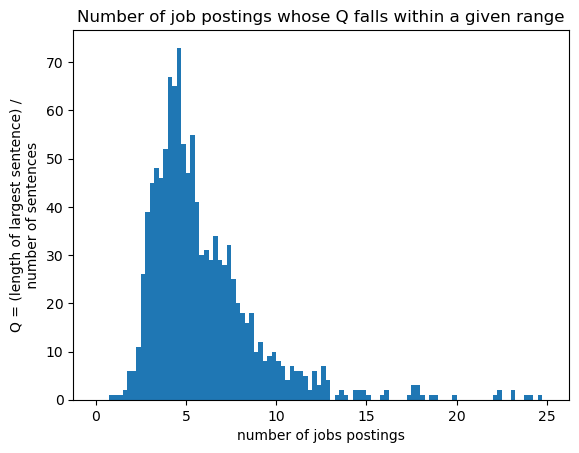

In [9]:
import matplotlib.pyplot as plt

plt.hist(n_sents_div_max_len_sents, bins = 100, range = [0, 25])
plt.title('Number of job postings whose Q falls within a given range')
plt.xlabel('number of jobs postings')
plt.ylabel('Q = (length of largest sentence) /\n number of sentences ')
plt.show()

Based on the above, as well as looking at the ads with Q<20 versus those with Q>20, a choice of Q = 20 was chosen as the cutoff.

In the future, it would be fun to train a model (likely a Longformer model/one that can handle longer text) to do this step in the process, but the above approach is adequate for now: 94% of the job postings are split adequately (see below).

In [10]:
split_badly = []
i = 0
for n in n_sents_div_max_len_sents:
    if (n > 20):
        split_badly.append(i)
    i += 1
    
len(split_badly)/len(l_sents)

0.06048053024026512

## Reconstructing the job posting from the list of sentences and the 'helper' string

A nice way of demonstrating what the pipeline does is by input a job posting into it, having the pipeline extract skills/qualifications, and then printing the job posting, except with the skills/qualifications highlighted. This requires an "inverse function" that takes the list of sentences, and outputs the original posting.

The slight difficulty with this is that the function that partitions the job ad into sentences uses the Python regular expression package, "re". It does not store the characters that the strings are split on. To address this, the "partition the job ads" function also creates a helper string. With this string, and the list of sentences, the posting can be reconstructed. See below for an example of what the helper string looks like:

In [11]:
sentences0, helper0 = partition_string(df['descr'][0])
helper0

'[1]\n[2]\n[3]\n[4] [5] [6] [7] [8] [9] [10]\n[11]\n[12] [13] [14]\n[15]\n[16]\n[17] [18] [19] [20] [21] [22] [23] [24] [25]\n[26]\n[27]\n[28]\n[29]'

To see that the list of sentences combined with the helper string allows for the posting to be reconstructed (most of the time), the following loop is run:

In [12]:
for i in range(len(df['descr'])):
    s, helper = partition_string(df['descr'][i])
    if (reconstruct_description(s, helper) != df['descr'][i]):
        print(i)

97
178
267
290
431


When these corner cases cases observed, it is apparent what the problem is. For example, one has the following in it "\n40\n", and so \_\_, **explain what the problem is**. Although a solution that, in all cases, works could be found, this approach is adequate for the purposes of the project.